# `astropy.io.fits`

In astropy, one of the most important function is `fits`, which is used for reading and writing fits file. `ccdproc` or any other packages which loads fits image is strongly recommended to use `astropy.io.fits`. This section is a summary of how to use this function.

In [3]:
from astropy.io import fits

hdul = fits.open('HST_Tutorial/Pluto.fits')
# hdul = HDU List = Header Data Unit List

print(type(hdul))
print()
hdul.info()
# prints out the information of the hdul.



<class 'astropy.io.fits.hdu.hdulist.HDUList'>

Filename: HST_Tutorial/Pluto.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU     314   ()      
  1  SCI         ImageHDU       175   (513, 512)   float32   
  2  ERR         ImageHDU        51   (513, 512)   float32   
  3  DQ          ImageHDU        43   (513, 512)   int16   
  4  D2IMARR     ImageHDU        15   (64, 32)   float32   
  5  D2IMARR     ImageHDU        15   (64, 32)   float32   
  6  WCSDVARR    ImageHDU        15   (64, 32)   float32   
  7  WCSDVARR    ImageHDU        15   (64, 32)   float32   
  8  WCSCORR     BinTableHDU     59   7R x 24C   [40A, I, A, 24A, 24A, 24A, 24A, D, D, D, D, D, D, D, D, 24A, 24A, D, D, D, D, J, 40A, 128A]   


* **TIP**: You can use `fitsinfo`, `fitsheader`, etc on terminal, too!

You may wonder what the `PRIMARY`, `SCI`, ect, are. These depend on the instrument you used for the observation; two most important things are `PRIMARY` and `SCI`, which means the primary (common) header and scientific image, respectively. I intentionally downloaded raw data, i.e., no much correction is done to the image (e.g., cosmic ray rejection). 

Basically there are two important information in `HDUList`: header and data (as its name indicates). You can check both by :

In [8]:
# Let me use SCI (index 1) only
header = hdul[1].header 
data   = hdul[1].data
print('which ccd chip is this? ', header['ccdchip'])


which ccd chip is this?  2


You can check the whole header by `print(header)`. What about data? In the following, I will show you how to plot the "zscale" image:

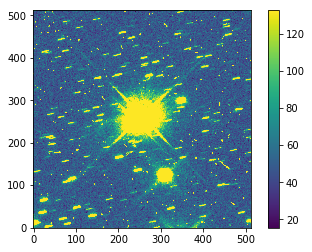

In [12]:
from matplotlib import pyplot as plt
from astropy.visualization import ZScaleInterval, ImageNormalize

def znorm(image, **kwargs):
    return ImageNormalize(image, interval=ZScaleInterval(**kwargs))

def zimshow(image, **kwargs):
    plt.imshow(image, norm=znorm(image, **kwargs), origin='lower')
    plt.colorbar()
    
zimshow(data)
plt.show()


Or you can just use ginga or ds9. 

-----

## Crop the Image

You can crop the image using various ways. One possible, and probably the most useful way is to use `ccdproc`. But this `ccdproc` is using some variant of `fits`: `CCDData`. This is used for pythonic image processing. So I will load the image in `CCDData`, not `HDUList` format:

In [15]:
from ccdproc import CCDData, trim_image
import numpy as np

data = CCDData(data = hdul[1].data, 
               header=hdul[0].header+hdul[1].header, 
               unit='adu')

# FITS-style:
data1 = trim_image(data, fits_section='[1:200, 1:100]')

# python-style:
data2 = trim_image(data[:100, :200])
# 0:100 means 0 to 99 in Python, so that the total number is same as fits (100 pixels)

print(np.sum(data1.subtract(data2)) == 0)

# data2.write('test.fits', overwrite=True)

True


Why did I use `header=hdul[0].header+hdul[1].header`? That is because `hdul[0]` contains the **common** header information, so if I skip this part, the header from `hdul[1]` is not perfect. If you try to use only `hdul[1].header`, you may get an error, or the output file (`test.fits`) may not contain any wcs information.

Also by using `fits_section`, you can freely choose Python convention or FITS convention for trimming the image. The above example returns the results `data1` and `data2` as `CCDData` format. But in this case, 